# Lesson 05 Assignment - Decision Tree


## About the dataset

<a href='https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)'>Breast Cancer Wisconsin Data Set</a>

Attribute Information:

1. Sample code number: id number 
2. Class: (2 for benign, 4 for malignant)
3. Clump Thickness: 1 - 10 
4. Uniformity of Cell Size: 1 - 10 
5. Uniformity of Cell Shape: 1 - 10 
6. Marginal Adhesion: 1 - 10 
7. Single Epithelial Cell Size: 1 - 10 
8. Bare Nuclei: 1 - 10 
9. Bland Chromatin: 1 - 10 
10. Normal Nucleoli: 1 - 10 
11. Mitoses: 1 - 10 
 

## Instructions

Using the <a href='https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/WI_Breast_Cancer.csv'>WI_Breast_Cancer csv file</a>, create a new notebook to build a decision tree classifier that would be able to detect whether a tumor is benign or malignant. Complete the following tasks and answer the questions:

1. Test both entropy and the gini coefficient. Which performs better and why?
2. What are the best hyperparameter settings for both?
3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?
4. Determine the AUC for the best model you can achieve. What are the precision and recall values and which might be the one you want to maximize?
5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?

In [1]:
import pandas as pd
import numpy as np

from subprocess import check_call

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Load and prepare data

In [2]:
def load_data(a_url, path):
    """Return a DataFrame containing a dataset from url or local path."""
    print('Trying to load the data set from a local file if it exists...')
    try:
        data_set = pd.read_csv(path, header = None)
    except FileNotFoundError:
        print('\tFile not found, loading from Internet...')
        data_set = pd.read_csv(a_url, header = None)
        print('\t\tData loaded from url')
    else:
        print('\tData loaded from local file')
    
    return data_set

In [3]:
url_data = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/WI_Breast_Cancer.csv'
local_path_data = './WI_Breast_Cancer.csv'

data = load_data(url_data, local_path_data)

print('Data shape:', data.shape)
print(data.dtypes)
print(data.head())

Trying to load the data set from a local file if it exists...
	Data loaded from local file
Data shape: (709, 11)
0      object
1      object
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10     object
dtype: object
        0  1    2    3    4    5    6     7    8    9  10
0  1000025  2  5.0  1.0  1.0  1.0  2.0   1.0  3.0  1.0  1
1  1002945  2  5.0  4.0  4.0  5.0  7.0  10.0  3.0  2.0  1
2  1015425  2  3.0  1.0  1.0  1.0  2.0   2.0  3.0  1.0  1
3  1016277  2  6.0  8.0  8.0  1.0  3.0   4.0  3.0  7.0  1
4  1017023  2  4.0  1.0  1.0  3.0  2.0   1.0  3.0  1.0  1


In [4]:
# Rename columns
column_names = ['sample_id', 'class', 'clump_thcknss', 'cell_sz_unfrmty',
            'cell_shape_unfrmty','mrgnl_adhesion','sngl_epithelial_cell_sz',
            'bare_nuclei','bland_chromatin', 'nrml_nucleoli', 'mitosis']
data.columns = column_names

In [5]:
# Remove rows containg # symbols
mask = data['sample_id'].str.contains('#')
indices = data.loc[mask, 'sample_id'].index
print('Rows containing # symbols:', indices)
data = data.drop(indices)
data = data.reset_index(drop = True)
print('Data shape after dropping rows with # symbols:', data.shape)

Rows containing # symbols: Int64Index([367, 438, 470, 488, 537, 538, 539, 540, 590, 622], dtype='int64')
Data shape after dropping rows with # symbols: (699, 11)


In [6]:
# Drop 'sample_id'
data = data.drop('sample_id', axis = 1)
print(data.head())

  class  clump_thcknss  cell_sz_unfrmty  cell_shape_unfrmty  mrgnl_adhesion  \
0     2            5.0              1.0                 1.0             1.0   
1     2            5.0              4.0                 4.0             5.0   
2     2            3.0              1.0                 1.0             1.0   
3     2            6.0              8.0                 8.0             1.0   
4     2            4.0              1.0                 1.0             3.0   

   sngl_epithelial_cell_sz  bare_nuclei  bland_chromatin  nrml_nucleoli  \
0                      2.0          1.0              3.0            1.0   
1                      7.0         10.0              3.0            2.0   
2                      2.0          2.0              3.0            1.0   
3                      3.0          4.0              3.0            7.0   
4                      2.0          1.0              3.0            1.0   

  mitosis  
0       1  
1       1  
2       1  
3       1  
4       1  


In [7]:
# Set 'mitosis' column as type float
data['mitosis'] = data['mitosis'].astype(float)

In [8]:
# Reset 2 and 4 as 0 and 1
# Class: (2 for benign, 4 for malignant)
mask_benign = data['class'] == '2'
data.loc[mask_benign, 'class'] = 0   # 0 for benign
data.loc[~mask_benign, 'class'] = 1  # 1 for malignant
data['class'] = data['class'].astype(int)
# print('Benign cases:', len(data[data['class'] == 0])) # --> 458
# print('Malignant cases:', len(data[data['class'] == 1])) # --> 241
print('Benign cases:', sum(data['class'] == 0)) # --> 458
print('Malignant cases:', sum(data['class'] == 1)) # --> 241
print(data.dtypes)

Benign cases: 458
Malignant cases: 241
class                        int64
clump_thcknss              float64
cell_sz_unfrmty            float64
cell_shape_unfrmty         float64
mrgnl_adhesion             float64
sngl_epithelial_cell_sz    float64
bare_nuclei                float64
bland_chromatin            float64
nrml_nucleoli              float64
mitosis                    float64
dtype: object


In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
class                      699 non-null int64
clump_thcknss              699 non-null float64
cell_sz_unfrmty            699 non-null float64
cell_shape_unfrmty         699 non-null float64
mrgnl_adhesion             699 non-null float64
sngl_epithelial_cell_sz    699 non-null float64
bare_nuclei                699 non-null float64
bland_chromatin            699 non-null float64
nrml_nucleoli              699 non-null float64
mitosis                    699 non-null float64
dtypes: float64(9), int64(1)
memory usage: 54.7 KB
None


## Assign the X (feature) and Y (class) Arrays and Split into Train and Test Data¶

In [10]:
# Ensure the decision tree is deterministic
np.random.seed(101)

feature_names = ['clump_thcknss', 'cell_sz_unfrmty',
            'cell_shape_unfrmty','mrgnl_adhesion','sngl_epithelial_cell_sz',
            'bare_nuclei','bland_chromatin', 'nrml_nucleoli', 'mitosis']
X = data[feature_names]
Y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 99)

## Re-sampling the training data doesn't improve the results

Original train dataset shape Counter({0: 363, 1: 196})
Original test dataset shape Counter({0: 95, 1: 45})


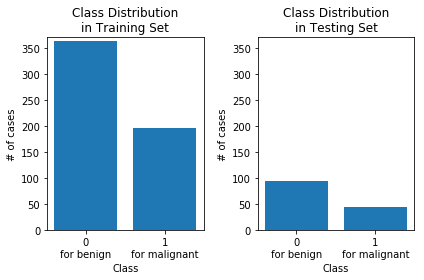

In [11]:
from collections import Counter
# from imblearn.over_sampling import SMOTE 

print('Original train dataset shape {}'.format(Counter(y_train)))
print('Original test dataset shape {}'.format(Counter(y_test)))

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2)

def plot_bar_class(axis, data, title):
    """Plot a sub-plot."""
    axis.bar(Counter(data).keys(), Counter(data).values())
    axis.set_xlabel('Class')
    axis.set_ylabel('# of cases')
    axis.set_ylim(0, 370)
    axis.set_title(title)
    axis.set_xticks([0, 1])
    axis.set_xticklabels(['0\nfor benign', '1\nfor malignant'])

plot_bar_class(ax0, Counter(y_train), 'Class Distribution\nin Training Set')
plot_bar_class(ax1, Counter(y_test), 'Class Distribution\nin Testing Set')

plt.tight_layout()
plt.show()

In [12]:
# # Re-sample training data
# sm = SMOTE(random_state = 42)
# X_train, y_train = sm.fit_sample(X_train, y_train)
# print('Resampled train dataset shape {}'.format(Counter(y_train)))

## Generate models

In [13]:
# Generate classification models

# Use Information Gain (entropy)
dec_tree_ent = DecisionTreeClassifier(criterion = 'entropy',
                                      max_depth = 4,  # Limit the # of decision levels
                                      min_samples_leaf = 2,  # Limit the # of examples for a split
                                     ).fit(X_train, y_train)
# Use Gini impurity (default) instead of Information Gain (entropy)
dec_tree_gini = DecisionTreeClassifier(max_depth = 4,
                                      ).fit(X_train, y_train)  

## Manipulate the probability threshold to imporve recall on positive cases

In [14]:
# Probability threshold: a cutoff value to classify cases
def get_predicted_test_labels(model_instance, test_XX, prob_threshold = 0.5):
    """Return predicted labels for the test data."""
    # Use predict_proba method to guess labels for the test set
    YY = (model_instance.predict_proba(test_XX.values)[:, 1] >= prob_threshold)
    YY = YY.astype(int)
    return YY

# Validate the entropy-based model
y_predict_ent = get_predicted_test_labels(dec_tree_ent, X_test, prob_threshold = 0.4)
# Validate the gini-based model
y_predict_gini = get_predicted_test_labels(dec_tree_gini, X_test)  # use default threshold

In [15]:
# # Validate the entropy-based model
# y_predict_ent = dec_tree_ent.predict(X_test)
# # Validate the gini-based model
# y_predict_gini = dec_tree_gini.predict(X_test)

## Evaluate the accuracy

In [16]:
# Generate the accuracy score for the entropy-based model
acc_ent = accuracy_score(y_test, y_predict_ent) * 100
print("Entopry-based model's accuracy is : {}%".format(acc_ent))

# Generate the accuracy score for the gini-based model
acc_gini = accuracy_score(y_test, y_predict_gini) * 100
print("Gini-based model's accuracy is : {}%".format(acc_gini))

Entopry-based model's accuracy is : 92.85714285714286%
Gini-based model's accuracy is : 92.85714285714286%


In [17]:
print('Entropy-based model confusion matrix')
ent_conf_matrix_obj = confusion_matrix(y_test, y_predict_ent)
conf_matrix_ent = pd.DataFrame(
    ent_conf_matrix_obj,
    columns=['Predicted benign', 'Predicted malignant'],
    index=['True benign', 'True malignant']
)
conf_matrix_ent

Entropy-based model confusion matrix


,Predicted benign,Predicted malignant
True benign,88,7
True malignant,3,42


In [18]:
print('Gini-based model confusion matrix')
gini_conf_matrix_obj = confusion_matrix(y_test, y_predict_gini)
conf_matrix_gini = pd.DataFrame(
    gini_conf_matrix_obj,
    columns=['Predicted benign', 'Predicted malignant'],
    index=['True benign', 'True malignant']
)
conf_matrix_gini

Gini-based model confusion matrix


,Predicted benign,Predicted malignant
True benign,90,5
True malignant,5,40


## Visualize the Decision Trees

In [19]:
with open("cancer_ent.dot", 'w') as dotfile1:
    tree.export_graphviz(dec_tree_ent,
                         out_file = dotfile1,
                         class_names = ['benign', 'malignant'],  # must be in alphabetical order
                         filled = True,
                         rounded = True,
                         feature_names = feature_names)

with open("cancer_gini.dot", 'w') as dotfile2:
    tree.export_graphviz(dec_tree_gini,
                         out_file = dotfile2,
                         class_names = ['benign', 'malignant'],
                         filled = True,
                         rounded = True,
                         feature_names = feature_names)

# Convert the dot file to a png using subprocess.check_call
check_call(['dot','-Tpng','cancer_ent.dot','-o','cancer_ent.png'])
check_call(['dot','-Tpng','cancer_gini.dot','-o','cancer_gini.png'])

0

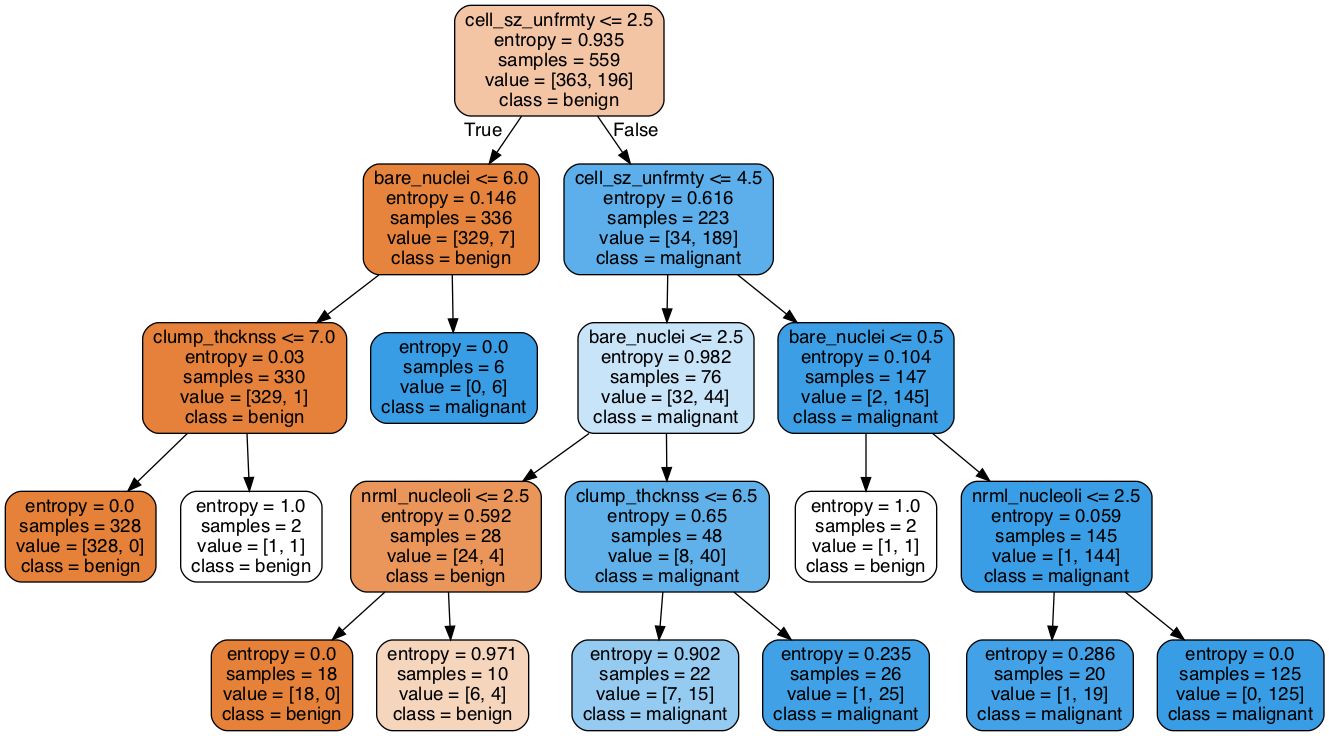

In [20]:
# Use IPython.display.Image
Image(filename = 'cancer_ent.png', width = 500, height = 500)

In [21]:
# Check the first split, i.e. if 'cell_sz_unfrmty' <= 2.5, then 'benign'
data.groupby(['class'])['cell_sz_unfrmty'].mean()  # 'cell_sz_unfrmty' is smaller for benign cases

class
0    1.325328
1    6.572614
Name: cell_sz_unfrmty, dtype: float64

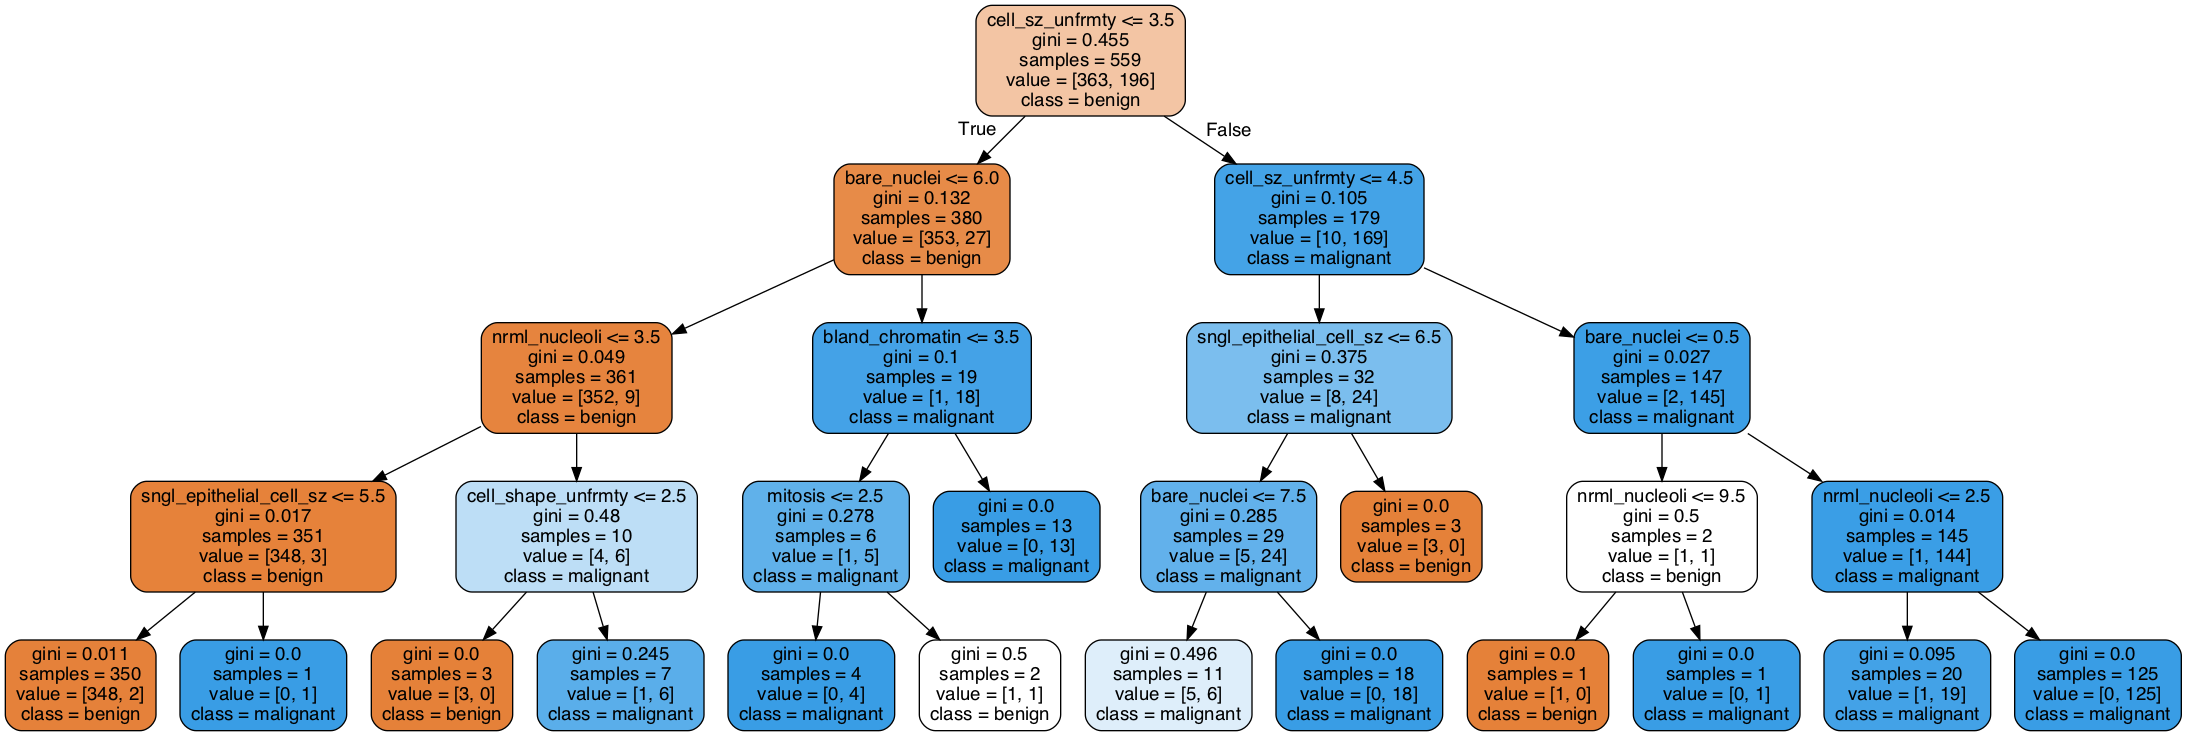

In [22]:
# Use IPython.display.Image
Image(filename = 'cancer_gini.png', width = 500, height = 500)

## AUC/ROC charts to compare the models

In [23]:
def do_roc_analysis(XX, YY, model, plot = True):
    """Return area under curve metric and prob. estimates; plot ROC curve."""
    # y = probability estimates of the positive class
    #  [:,1] for predicted probabilities for the positive label only
    y = model.predict_proba(XX.values)[:, 1]
    LW = 1.5  # line width for plots
    LL = "lower right"  # legend location
    LC = "darkgreen"  # Line Color
    # False Positive Rate, True Posisive Rate, probability thresholds
    fpr, tpr, th = metrics.roc_curve(YY.astype(int), y)
    print('First 10 or less prob.thresholds:', np.round(th[:10], 3))
    AUC = metrics.auc(fpr, tpr)
    print('AUC: {:.3f}'.format(AUC))

    if plot:
        plt.figure()
        plt.title('ROC curve for Connections Dataset, {} Model'.format(type(model)))
        plt.xlim([-0.1, 1.0])
        plt.ylim([-0.1, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(fpr, tpr, color=LC, lw=LW,
                 label='ROC curve (area = %0.2f)' % AUC)
        plt.plot(fpr, tpr, 'bo',
                 label='ROC curve (area = %0.2f)' % AUC, alpha = 0.2)
        # reference line for random classifier
        plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--')
        plt.legend(loc=LL)
        plt.show()

    return AUC, y


ROC ANALYSIS for the entropy-based model
First 10 or less prob.thresholds: [2.    1.    0.962 0.95  0.682 0.4   0.   ]
AUC: 0.937


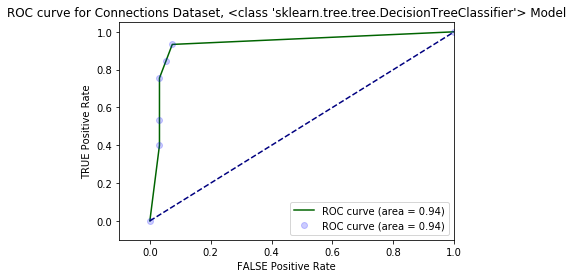

In [24]:
print("\nROC ANALYSIS for the entropy-based model")
_, _ = do_roc_analysis(X_test, y_test, dec_tree_ent)


ROC ANALYSIS for the gini-based model
First 10 or less prob.thresholds: [2.    1.    0.95  0.857 0.545 0.006 0.   ]
AUC: 0.906


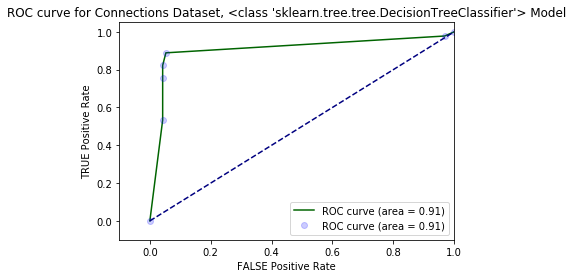

In [25]:
print("\nROC ANALYSIS for the gini-based model")
_, _ = do_roc_analysis(X_test, y_test, dec_tree_gini)

In [26]:
def print_metrics(conf_matrix):
    """Calculate and print metics from the input confusion matrix."""
    true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()
    accuracy = (true_neg + true_pos) / sum(sum(conf_matrix))
    recall = true_pos / (true_pos + false_neg)
    specificity = true_neg / (true_neg + false_pos)
    FPR = false_pos / (false_pos + true_neg)
    precision = true_pos / (true_pos + false_pos)
    f1 = 2 / ((1 / recall) + (1 / precision))
    print_string = """Metrics:
    Accuracy (total correct predictions): {:.4f}
    Specificity (proportion of correctly\n\tlabeled benign cases of all\n\ttruly malignant cases): {:.4f}
    Recall (proportion of correctly\n\tlabeled malignant cases of all\n\ttruly malignant cases): {:.4f}
    Precision (proportion of correctly\n\tlabeled malignant cases of all\n\tcases labeled as malignant): {:.4f}
    False Positive Rate (probability of false alarm): {:.4f}
    F1 score (something like an average of precision and recall): {:.4f}
    """
    print(print_string.format(accuracy, specificity, recall, precision, FPR, f1))

In [27]:
# print metrics for the entropy-based model
print_metrics(ent_conf_matrix_obj)

Metrics:
    Accuracy (total correct predictions): 0.9286
    Specificity (proportion of correctly
	labeled benign cases of all
	truly malignant cases): 0.9263
    Recall (proportion of correctly
	labeled malignant cases of all
	truly malignant cases): 0.9333
    Precision (proportion of correctly
	labeled malignant cases of all
	cases labeled as malignant): 0.8571
    False Positive Rate (probability of false alarm): 0.0737
    F1 score (something like an average of precision and recall): 0.8936
    


In [28]:
# print metrics for the gini-based model
print_metrics(gini_conf_matrix_obj)

Metrics:
    Accuracy (total correct predictions): 0.9286
    Specificity (proportion of correctly
	labeled benign cases of all
	truly malignant cases): 0.9474
    Recall (proportion of correctly
	labeled malignant cases of all
	truly malignant cases): 0.8889
    Precision (proportion of correctly
	labeled malignant cases of all
	cases labeled as malignant): 0.8889
    False Positive Rate (probability of false alarm): 0.0526
    F1 score (something like an average of precision and recall): 0.8889
    


## Summary

As part of data preparation, I removed rows containing comments in the original file and removed the 'sample_id' column. I set class labels to be 0  for benign cases and 1 for malignant cases. Then I split the data into the training and testing sets. I also attempted to apply SMOTE to balance the dataset before the training, as well as, separately, to set the class_weight parameter equal to ‘balanced’ during the training, to prevent the tree from being biased toward the dominant class but that did not improve the results.

<i><u>1.  Test both entropy and the gini coefficient. Which performs better and why?</u></i>

<b>A scikit-learn's decision tree produces almost the same results for both entropy and gini index criteria. I think this is because these measures are similar and make similar splits. By manipulating the probability threshold, max_depth and min_samples parameters, I achieved marginal improvement for the entropy-based model compared to the gini model. But I am afraid that the improvement is due to that I tuned the model to the testing set because I divided the data into training and testing sets rather than into training, validation and testing sets.</b>

<i><u>2. What are the best hyperparameter settings for both?</u></i>

<b>For the gini-based model, by trial, I was unable to find any parameters that would make it perform better compared to its default parameters. At the same time, setting max_depth to 4 makes the gini decision tree model much simpler without any degradation in performance. For the entropy-based model, I achieved a very slight improvement in its predictive performance by setting the probability threshold to 0.4 (a cutoff value to better predict rarer malignant cases), max_depth to 4 (to limit the number of levels in the tree) and min_samples_leaf to 2 (to set the minimum number of cases required for making a split).</b>

<i><u>3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?</u></i>

<b>Features selected are very similar at the top of the tree, but each criterion determines a slightly different threshold for making a split. For example, they both start at the same feature as the root node but set the threshold for the split at 2.5 and 3.5. Differences in the features selected arise further down the tree.</b>

<i><u>4. Determine the AUC for the best model you can achieve. What are the precision and recall values and which might be the one you want to maximize?</u></i>

<b>The AUC for the better performing entropy-based decision tree is 0.94. Precision is 0.86 and recall for the positive class (i.e. the proportion of correctly labeled malignant cases out of all truly malignant cases) is 0.93. Recall, as a metric that shows how well a classifier predicts a particular class, is the metric that I want to maximize for both classes. I think precision could be used similarly.</b>

<i><u>5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?</u></i>

<b>This type of machine learning algorithm might be useful for breast cancer analysis as a tool for focusing a doctor's attention on particular features which the model uses to make the decision splits.</b>